In [35]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

In [65]:
#file=r'/Users/YOURPATH/testcv.png'
file=r'C:\\Users\\Shiva\\Downloads\\test2.png'
img = cv2.imread(file,0)
print(type(img))

<class 'numpy.ndarray'>


In [66]:
#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)

In [67]:
#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('cv_inverted.png',img_bin)

True

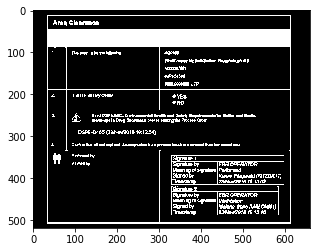

In [68]:
#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

In [69]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100

In [70]:
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

In [71]:
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

In [72]:
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

In [73]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("vertical.jpg",vertical_lines)

True

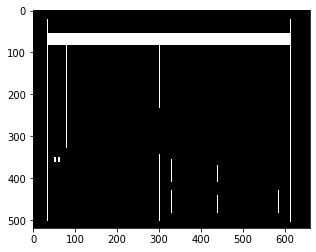

In [74]:
#Plot the generated image
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

In [75]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("horizontal.jpg",horizontal_lines)

True

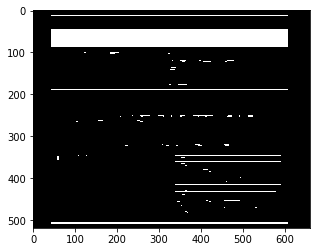

In [76]:
#Plot the generated image
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

In [77]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

In [78]:
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("img_vh.jpg", img_vh)

True

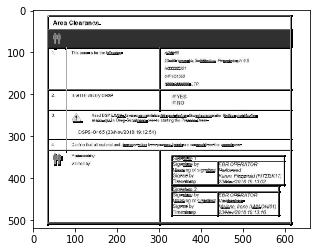

In [79]:
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
#Plotting the generated image
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

In [80]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [81]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


In [82]:
# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours)

In [83]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#Get mean of heights
mean = np.mean(heights)

In [84]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap=’gray’)
#plt.show()

In [85]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])

In [86]:
print(column)
print(row)

[[521, 469, 24, 5], [546, 389, 20, 5]]
[[[37, 336, 263, 168], [37, 310, 42, 23], [37, 240, 42, 66], [37, 193, 42, 44], [37, 94, 42, 95], [37, 17, 575, 28]], [[49, 343, 24, 30], [82, 310, 530, 23], [82, 240, 530, 66], [82, 193, 218, 44], [82, 94, 218, 95]], [[95, 264, 24, 5]], [[101, 345, 39, 5], [114, 100, 24, 5], [143, 32, 20, 5]], [[148, 262, 42, 6], [171, 201, 21, 5], [176, 100, 40, 7]], [[187, 249, 35, 8], [204, 260, 21, 5]], [[213, 318, 44, 8], [227, 249, 64, 8], [237, 260, 39, 9]], [[249, 322, 23, 5], [275, 260, 21, 5]], [[276, 318, 23, 5], [290, 249, 33, 8]], [[301, 319, 34, 7]], [[304, 336, 308, 168], [304, 193, 308, 44], [304, 94, 308, 95], [315, 102, 23, 5]], [[316, 176, 62, 6], [316, 172, 24, 5], [320, 140, 31, 5], [320, 119, 25, 6]], [[321, 135, 31, 5]], [[322, 249, 21, 8], [323, 98, 20, 5]], [[328, 344, 277, 151]], [[333, 436, 105, 51], [333, 422, 251, 10], [333, 418, 105, 1], [333, 363, 105, 51], [333, 349, 264, 10], [334, 318, 27, 9]], [[335, 453, 28, 7], [335, 379, 29, 

In [87]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [88]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [89]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

In [90]:
print(type(finalboxes))

<class 'list'>


In [91]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [92]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

In [93]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")

                                                    0  1
0     Petpomecimby\ni Verified by     Area Clearance.   
1     Confirm that all material and Cmegiiog fap e...   
2                                                       
3                                                       
4                                                       
5                                                       
6                                                       
7                                                       
8                                                       
9                                                       
10   Karen, Fiteggraid (FITZGK17)\n2 eltebewar/201...   
11                                                      
12                                                      
13                                                      
14   Karen, Fitezgrald (FITZGK17)\n2 eltebewar/201...   
15   Signeiate by\nMang Of scum\nSignet by\nTimesi...   
16                             